In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import matplotlib
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter


df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# NON VOTING EQUIPMENT TO EXCLUDE/SEPARATE FROM ANALYSIS
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable']

# EXCLUDE ELECTRONIC VOTING
exclude_remote = ['Internet Voting: Email',
                    'Internet Voting: Web Portal',
                    'Internet Voting: Fax',
                    'Remote Ballot Marking System: Client-Side',
                    'Remote Ballot Marking System: Server-Side']

# OTHER EQUIPMENT TYPES DEEMED ACCEPTABLE
voting_equipment_types = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment_types)]

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'

fe = font_manager.FontEntry(
    fname='bpc_fonts/Redesign-3/Styrene/StyreneA-Black.otf',
    name='StyreneABlack')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='bpc_fonts/Redesign-3/Styrene/StyreneA-Medium.otf',
    name='StyreneAMedium')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='bpc_fonts/Redesign-3/Styrene/StyreneA-Regular.otf',
    name='StyreneARegular')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

matplotlib.rcParams['font.family'] = 'StyreneARegular' # = 'your custom ttf font name'


/var/folders/pn/m02s2pkn6xs36t5ry5l4mrkm0000gn/T/ipykernel_35326/1035694958.py:9: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


# QR code analysis

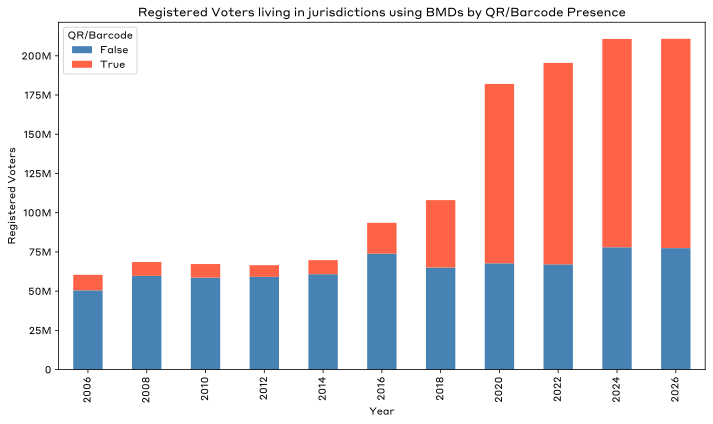

In [11]:
# Filter for Ballot Marking Devices
df_bmd = df[df['Equipment Type'].str.contains('Ballot Marking Device|BMD', case=False, na=False)]


# Group by Year and QR/Barcode, summing Registered Voters
grouped = df_bmd.groupby(['Year', 'QR/Barcode'])['Registered Voters'].sum().unstack(fill_value=0)

# Plot as stacked bar
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color={True: 'tomato', False: 'steelblue'})


# Format large numbers to "1.1M" style
def human_readable(x, pos):
    if x >= 1_000_000:
        return f'{x * 1e-6:.0f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.0f}K'
    else:
        return str(int(x))

ax.yaxis.set_major_formatter(FuncFormatter(human_readable))


plt.title('Registered Voters living in jurisdictions using BMDs by QR/Barcode Presence')
plt.xlabel('Year')
plt.ylabel('Registered Voters')
plt.legend(title='QR/Barcode')
plt.tight_layout()
plt.show()


# Analyze models

## Which BMDs can be configured to either print barcodes or not?
Only the Dominion ImageCast X. In 2026, 34% of jurisdictions with the ICX (all in MI, CO, WI) have it configured to *not* print QR/barcodes.

In [12]:
df_bmd['Manufacturer Model'] = df_bmd['Manufacturer'] + ' ' + df_bmd['Model']


# find percentage of BMDs that use QR/barcode
qr_code_dict = df_bmd.groupby('Manufacturer Model')['QR/Barcode'].agg(lambda x: x.sum() / len(x)).to_dict()
qr_code_dict


/var/folders/pn/m02s2pkn6xs36t5ry5l4mrkm0000gn/T/ipykernel_35326/238705588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmd['Manufacturer Model'] = df_bmd['Manufacturer'] + ' ' + df_bmd['Model']


{'Avante Vote-Trakker Ballot Marking Device': 0.0,
 'Clear Ballot ClearAccess': 0.0,
 'Clear Ballot ClearMark': 0.0,
 'Democracy Live OmniBallot Tablet': 0.0,
 'Dominion ImageCast': 0.0,
 'Dominion ImageCast Evolution': 0.0,
 'Dominion ImageCast Precinct BMD': 0.0,
 'Dominion ImageCast X BMD': 0.8475177304964538,
 'ES&S AutoMARK': 0.0,
 'ES&S ExpressVote': 1.0,
 'ES&S ExpressVote Tabulator': 1.0,
 'ES&S ExpressVote XL': 1.0,
 'ES&S InkaVote Plus': 0.0,
 'Hart InterCivic Verity Duo': 0.0,
 'Hart InterCivic Verity Touch Writer': 0.0,
 'IVS Inspire Ballot Marking System': 0.0,
 'IVS Inspire Vote By Phone': 1.0,
 'Los Angeles County VSAP BMD': 1.0,
 'Populex PopulexSlate': 1.0,
 'Prime III One4All': 0.0,
 'Unisyn OpenElect FVT': 1.0,
 'Unisyn OpenElect OVI': 1.0,
 'Unisyn OpenElect OVI-VC': 1.0,
 'Vote-PAD Vote-PAD Ballot Marking System': 0.0,
 'VotingWorks VxMark': 1.0}

In [13]:
# what about in 2026?
df_bmd[df_bmd['Year']==2026].groupby(['Manufacturer Model'])['QR/Barcode'].value_counts(normalize=True).unstack()

QR/Barcode,False,True
Manufacturer Model,,
Clear Ballot ClearAccess,1.0,<NA>
Clear Ballot ClearMark,1.0,<NA>
Democracy Live OmniBallot Tablet,1.0,<NA>
Dominion ImageCast Evolution,1.0,<NA>
Dominion ImageCast Precinct BMD,1.0,<NA>
Dominion ImageCast X BMD,0.341146,0.658854
ES&S AutoMARK,1.0,<NA>
ES&S ExpressVote,<NA>,1.0
ES&S ExpressVote Tabulator,<NA>,1.0


In [14]:
uses_qr_code = df_bmd.groupby('Manufacturer Model')['QR/Barcode'].agg(lambda x: x.sum() / len(x)).to_dict()


In [15]:
'x'.startswith('x')

True

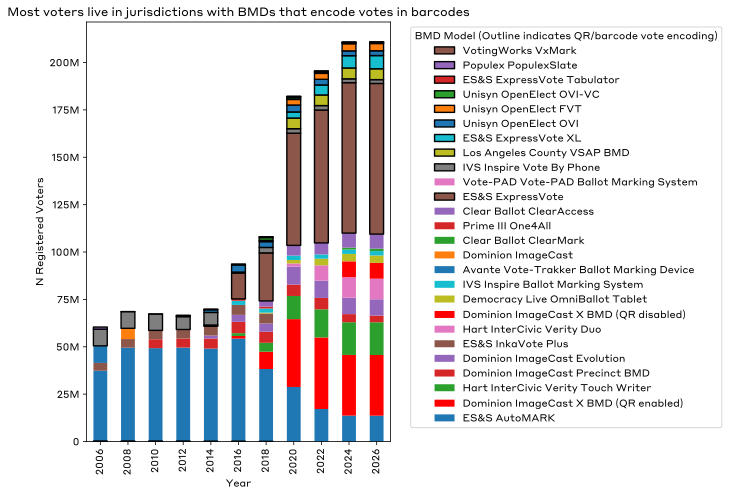

In [16]:
df_bmd.loc[(df_bmd['Manufacturer Model'] == 'Dominion ImageCast X BMD') & (df_bmd['QR/Barcode']==True), 'Manufacturer Model'] = 'Dominion ImageCast X BMD (QR enabled)'
df_bmd.loc[(df_bmd['Manufacturer Model'] == 'Dominion ImageCast X BMD') & (df_bmd['QR/Barcode']==False), 'Manufacturer Model'] = 'Dominion ImageCast X BMD (QR disabled)'

# Group by Year and Manufacturer Model, summing registered voters
grouped = df_bmd.groupby(['Year', 'Manufacturer Model'])['Registered Voters'].sum().unstack(fill_value=0)

# Optional: sort columns by total usage over all years (for legend readability)
grouped = grouped[grouped.sum().sort_values(ascending=False).index]

# Sort the columns based on QR/Barcode usage (True first, then False)
sorted_columns = sorted(grouped.columns, key=lambda x: uses_qr_code.get(x, False), reverse=False)
# modify the order of columns to have QR-enabled/disabled Dominion ImageCast X together
sorted_columns = sorted_columns[0:7] + sorted_columns[8:15] + [sorted_columns[7]] + [sorted_columns[16]] + [sorted_columns[15]] + sorted_columns[17:]
grouped = grouped[sorted_columns]




# # Get list of all columns
# models = grouped.columns

# # Pick a colormap for the other models
# # cmap = cm.get_cmap('tab20', len(models))  # or any other colormap
# # matplotlib.colormaps['prism']
# cmap = plt.get_cmap('tab20', len(models))

# # Create a base color mapping
# color_mapping = {}
# default_color_iter = iter(cmap.colors)

# # Assign a specific color to both Dominion QR-enabled/disabled
# for model in models:
#     if model.startswith('Dominion ImageCast X BMD'):
#         # Assign the same color to both QR-enabled and QR-disabled'
#         color_mapping[model] = 'red'
#     else:
#         color_mapping[model] = next(default_color_iter)

# color_mapping['ES&S AutoMARK'] = color_mapping['VotingWorks VxMark']

# # Plot
# ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 7), color=[color_mapping[col] for col in grouped.columns])

ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 7))

# Outline bars with QR/Barcode usage (True)
for i, year in enumerate(grouped.index):
    for j, manufacturer_model in enumerate(grouped.columns):
        if uses_qr_code.get(manufacturer_model, False):  # Check if model uses QR/Barcode
            # Get the height of the bar for that year and manufacturer model
            bar_height = grouped.iloc[i, j]
            # Outline that segment (QR code segment) by plotting over it
            ax.patches[j * len(grouped) + i].set_edgecolor('black')
            ax.patches[j * len(grouped) + i].set_linewidth(1.4)
        if manufacturer_model.startswith('Dominion ImageCast X BMD'):
            ax.patches[j * len(grouped) + i].set_facecolor('red')

ax.yaxis.set_major_formatter(FuncFormatter(human_readable))


plt.title('Most voters live in jurisdictions with BMDs that encode votes in barcodes')
plt.xlabel('Year')
plt.ylabel('N Registered Voters')
plt.legend(title='BMD Model (Outline indicates QR/barcode vote encoding)', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)
plt.tight_layout()
plt.savefig('figs/bmd_barcode.png', dpi=300, bbox_inches='tight')



# Are jurisdictions that Biden won in 2020 more likely to have BMDs that encode votes using barcodes or QR codes?

In [17]:
df_pres = pd.read_csv("pres_data/countypres_2000-2020.csv")
df_pres = df_pres[df_pres["year"]==2020]
df_pres["candidate"].unique()

array(['JOSEPH R BIDEN JR', 'OTHER', 'DONALD J TRUMP', 'JO JORGENSEN'],
      dtype=object)

In [18]:
## GET 2020 TRUMP MARGIN OF VICTORY OVER BIDEN

# Filter for just Trump and Biden
df_filtered = df_pres[df_pres['candidate'].isin(['DONALD J TRUMP', 'JOSEPH R BIDEN JR'])]

# Group by state and county, summing candidate votes and getting total votes (should be the same across candidates)
df_grouped = df_filtered.groupby(
    ['state', 'county_name', 'county_fips', 'candidate']
).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'first'  # assuming totalvotes is the same for both candidates within a county
}).unstack()

# Flatten the column MultiIndex
df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]

# Rename for clarity
df_grouped = df_grouped.rename(columns={
    'candidatevotes_DONALD J TRUMP': 'trump_votes',
    'candidatevotes_JOSEPH R BIDEN JR': 'biden_votes',
    'totalvotes_DONALD J TRUMP': 'total_votes'  # or _JOSEPH R BIDEN JR, both should be same
})

# Calculate raw and percent margin
df_grouped['trump_margin'] = df_grouped['trump_votes'] - df_grouped['biden_votes']
df_grouped['trump_margin_pct'] = df_grouped['trump_margin'] / df_grouped['total_votes'] * 100

# Optional: sort by percent margin
df_grouped = df_grouped.sort_values(by='trump_margin_pct', ascending=False)

df_grouped.reset_index(inplace=True)

df_trump = df_grouped[["county_fips","trump_margin_pct"]]

In [19]:
## CLEAN FIPS CODE OF BMD DATA FOR MATCHING

df_bmd_2024 = df_bmd[df_bmd["Year"]==2024]
df_bmd_2024["county_fips"] = df_bmd_2024["FIPS code"].str[:5] # removes extra string that would normally designate precinct
df_bmd_2024['county_fips'] = df_bmd_2024['county_fips'].astype(str).str.zfill(5)
df_bmd_2024.sample(2)

/var/folders/pn/m02s2pkn6xs36t5ry5l4mrkm0000gn/T/ipykernel_35326/752344465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmd_2024["county_fips"] = df_bmd_2024["FIPS code"].str[:5] # removes extra string that would normally designate precinct
/var/folders/pn/m02s2pkn6xs36t5ry5l4mrkm0000gn/T/ipykernel_35326/752344465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmd_2024['county_fips'] = df_bmd_2024['county_fips'].astype(str).str.zfill(5)


,Year,FIPS code,State,Jurisdiction,Registered Voters,Equipment Type,Manufacturer,Model,First Year in Use,Years in Use,...,QR/Barcode,VVPAT,Election Day Standard,Election Day Accessible,Early Voting Standard,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage,Manufacturer Model,county_fips
128800,2024,3005700000,Montana,Madison County,1201,Ballot Marking Device,ES&S,ExpressVote,2020,4,...,True,<NA>,False,True,False,True,False,<NA>,ES&S ExpressVote,30057
179605,2024,4604100000,South Dakota,Dewey County,3351,Ballot Marking Device,ES&S,ExpressVote,2020,4,...,True,<NA>,False,True,False,True,False,<NA>,ES&S ExpressVote,46041


In [20]:
## JOIN 2024 EQUIPMENT AND 2020 RESULTS DATA

df_trump['county_fips'] = df_trump['county_fips'].astype(int).astype(str).str.zfill(5)

df_merged = pd.merge(
    df_bmd_2024,
    df_trump,
    left_on='county_fips',
    right_on='county_fips',
    how='left'
)

/var/folders/pn/m02s2pkn6xs36t5ry5l4mrkm0000gn/T/ipykernel_35326/1507604973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump['county_fips'] = df_trump['county_fips'].astype(int).astype(str).str.zfill(5)


In [21]:
df_merged.dropna(subset=['trump_margin_pct'],inplace=True)
df_merged['trump_won'] = df_merged['trump_margin_pct'] > 0
df_merged[["QR/Barcode","trump_margin_pct","trump_won"]]

,QR/Barcode,trump_margin_pct,trump_won
0,True,44.418437,True
1,True,53.762343,True
2,True,7.663054,True
3,True,57.727983,True
4,True,80.002175,True
...,...,...,...
5957,True,50.341358,True
5958,True,-37.242172,False
5959,True,62.427318,True
5960,True,64.335317,True


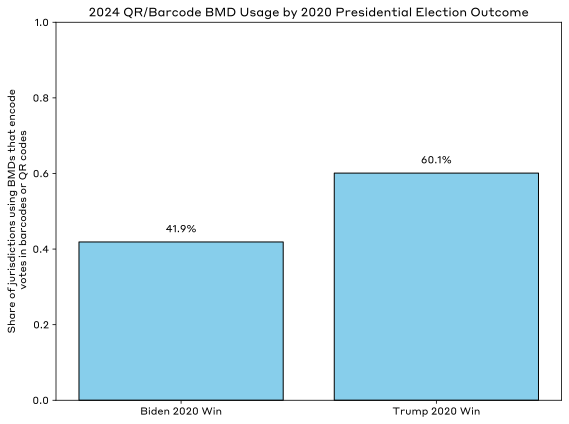

In [22]:
import matplotlib.pyplot as plt

# Group by whether Trump won and compute the mean QR usage
qr_by_trump = df_merged.groupby('trump_won')["QR/Barcode"].mean().reset_index()

# Convert Boolean to readable labels
qr_by_trump["trump_won"] = qr_by_trump["trump_won"].map({True: "Trump 2020 Win", False: "Biden 2020 Win"})

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(qr_by_trump["trump_won"], qr_by_trump["QR/Barcode"], color="skyblue", edgecolor="black")
plt.ylim(0, 1)
plt.ylabel("Share of jurisdictions using BMDs that encode\n votes in barcodes or QR codes")
plt.title("2024 QR/Barcode BMD Usage by 2020 Presidential Election Outcome")

# Annotate with percentage
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.1%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()